In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [3]:
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'

In [4]:
# Get baseline model
bl_df = pd.read_csv(f'{results_path}/clmbr/pretrained/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/uni_align_eval.csv')
bl_df['model'] = 'BL'
rd_df = pd.read_csv(f'{results_path}/clmbr/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_0.001_temp_0.01_pool_rand_day/uni_align_eval.csv')
rd_df['model'] = f'rand_day'
mr_df = pd.read_csv(f'{results_path}/clmbr/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_0.001_temp_0.01_pool_mean_rep/uni_align_eval.csv')
mr_df['model'] = f'mean_rep'
dp_df = pd.read_csv(f'{results_path}/clmbr/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_0.001_temp_0.01_pool_diff_pat/uni_align_eval.csv')
dp_df['model'] = f'diff_pat'
clr_df = pd.read_csv(f'{results_path}/clmbr/cl_rep/best/uni_align_eval.csv')
clr_df['model'] = f'cl_rep'

   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split CLMBR model
2           2   alignment  0.160163  0.300720  0.242888  test    BL    BL
3           3  uniformity  0.097675 -0.116733  0.061229  test    BL    BL
   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split CLMBR     model
2           2   alignment  0.295640  0.551347  0.417061  test    RD  rand_day
3           3  uniformity  0.102013 -0.116733  0.061229  test    RD  rand_day
   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split CLMBR     model
2           2   alignment  0.272699  0.532674  0.446107  test    MR  mean_rep
3           3  uniformity  0.097684 -0.116733  0.061229  test    MR  mean_rep
   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split CLMBR     model
2           2   alignment  0.299404  0.550552  0.421084  test    DP  diff_pat
3           3  uniformity  0.097931 -0.120844  0.065340  test    DP  diff_pat
   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split   CLMBR   mode

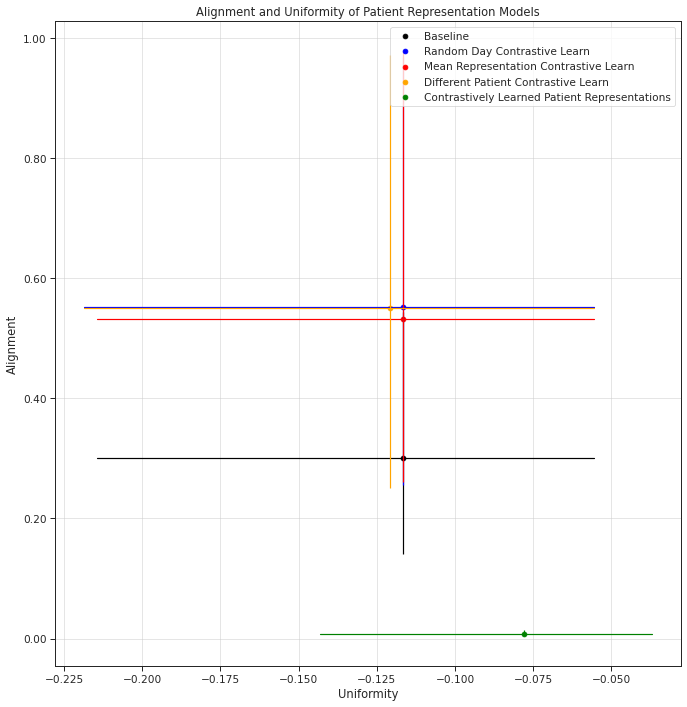

In [8]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
plt.tight_layout(w_pad=1,h_pad=2,rect=[0.05,0.15,1,0.95])


bl_evals = bl_df.query('split=="test"')
rd_evals = rd_df.query('split=="test"')
mr_evals = mr_df.query('split=="test"')
dp_evals = dp_df.query('split=="test"')
clr_evals = clr_df.query('split=="test"')

bl_evals['upper_ci'] = (bl_evals['upper_ci'] - bl_evals['med_ci']).abs()
bl_evals['lower_ci'] = (bl_evals['med_ci'] - bl_evals['lower_ci']).abs()

print(bl_evals)

rd_evals['upper_ci'] = (rd_evals['upper_ci'] - rd_evals['med_ci']).abs()
rd_evals['lower_ci'] = (rd_evals['med_ci'] - rd_evals['lower_ci']).abs()

print(rd_evals)

mr_evals['upper_ci'] = (mr_evals['upper_ci'] - mr_evals['med_ci']).abs()
mr_evals['lower_ci'] = (mr_evals['med_ci'] - mr_evals['lower_ci']).abs()

print(mr_evals)

dp_evals['upper_ci'] = (dp_evals['upper_ci'] - dp_evals['med_ci']).abs()
dp_evals['lower_ci'] = (dp_evals['med_ci'] - dp_evals['lower_ci']).abs()

print(dp_evals)

clr_evals['upper_ci'] = (clr_evals['upper_ci'] - clr_evals['med_ci']).abs()
clr_evals['lower_ci'] = (clr_evals['med_ci'] - clr_evals['lower_ci']).abs()

print(clr_evals)

p1 = axes.scatter(
    bl_evals.query('metric=="uniformity"')['med_ci'],
    bl_evals.query('metric=="alignment"')['med_ci'],
    color = 'black'
)

axes.errorbar(
    bl_evals.query('metric=="uniformity"')['med_ci'],
    bl_evals.query('metric=="alignment"')['med_ci'],
    bl_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='black'
)

axes.plot(
    [bl_evals.query('metric=="uniformity"')['med_ci'] - bl_evals.query('metric=="uniformity"')['lower_ci'],bl_evals.query('metric=="uniformity"')['med_ci'] + bl_evals.query('metric=="uniformity"')['upper_ci']],
    [bl_evals.query('metric=="alignment"')['med_ci'], bl_evals.query('metric=="alignment"')['med_ci']],
    color='black'
)

p2 = axes.scatter(
    rd_evals.query('metric=="uniformity"')['med_ci'],
    rd_evals.query('metric=="alignment"')['med_ci'],
    color = 'blue'
)

axes.errorbar(
    rd_evals.query('metric=="uniformity"')['med_ci'],
    rd_evals.query('metric=="alignment"')['med_ci'],
    rd_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='blue'
)

axes.plot(
    [rd_evals.query('metric=="uniformity"')['med_ci'] - rd_evals.query('metric=="uniformity"')['lower_ci'], rd_evals.query('metric=="uniformity"')['med_ci'] + rd_evals.query('metric=="uniformity"')['upper_ci']],
    [rd_evals.query('metric=="alignment"')['med_ci'], rd_evals.query('metric=="alignment"')['med_ci']],
    color='blue'
)

p3 = axes.scatter(
    mr_evals.query('metric=="uniformity"')['med_ci'],
    mr_evals.query('metric=="alignment"')['med_ci'],
    color = 'red'
)

axes.errorbar(
    mr_evals.query('metric=="uniformity"')['med_ci'],
    mr_evals.query('metric=="alignment"')['med_ci'],
    mr_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='red'
)

axes.plot(
    [mr_evals.query('metric=="uniformity"')['med_ci'] - mr_evals.query('metric=="uniformity"')['lower_ci'], mr_evals.query('metric=="uniformity"')['med_ci'] + mr_evals.query('metric=="uniformity"')['upper_ci']],
    [mr_evals.query('metric=="alignment"')['med_ci'], mr_evals.query('metric=="alignment"')['med_ci']],
    color='red'
)

p4 = axes.scatter(
    clr_evals.query('metric=="uniformity"')['med_ci'],
    clr_evals.query('metric=="alignment"')['med_ci'],
    color = 'green'
)

axes.errorbar(
    clr_evals.query('metric=="uniformity"')['med_ci'],
    clr_evals.query('metric=="alignment"')['med_ci'],
    clr_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='green'
)

axes.plot(
    [clr_evals.query('metric=="uniformity"')['med_ci'] - clr_evals.query('metric=="uniformity"')['lower_ci'], clr_evals.query('metric=="uniformity"')['med_ci'] + clr_evals.query('metric=="uniformity"')['upper_ci']],
    [clr_evals.query('metric=="alignment"')['med_ci'], clr_evals.query('metric=="alignment"')['med_ci']],
    color='green'
)

p5 = axes.scatter(
    dp_evals.query('metric=="uniformity"')['med_ci'],
    dp_evals.query('metric=="alignment"')['med_ci'],
    color = 'orange'
)

axes.errorbar(
    dp_evals.query('metric=="uniformity"')['med_ci'],
    dp_evals.query('metric=="alignment"')['med_ci'],
    dp_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='orange'
)

axes.plot(
    [dp_evals.query('metric=="uniformity"')['med_ci'] - dp_evals.query('metric=="uniformity"')['lower_ci'], dp_evals.query('metric=="uniformity"')['med_ci'] + dp_evals.query('metric=="uniformity"')['upper_ci']],
    [dp_evals.query('metric=="alignment"')['med_ci'], dp_evals.query('metric=="alignment"')['med_ci']],
    color='orange'
)

# axes.yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
axes.grid(which='major', linewidth=0.5, axis='y')
axes.grid(which='major', linewidth=0.5, axis='x')

axes.set_title('Alignment and Uniformity of Patient Representation Models')


axes.set_xlabel('Uniformity')
# axes.spines['bottom'].set_color('white')
# axes.tick_params(axis='x', length=0)  
axes.set_ylabel('Alignment')
axes.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes.legend([p1,p2,p3,p5,p4],['Baseline','Random Day Contrastive Learn', 'Mean Representation Contrastive Learn', 'Different Patient Contrastive Learn', 'Contrastively Learned Patient Representations'])


# axes.spines['left'].set_color('white')
# axes.tick_params(axis='y', length=0)
# sns.despine(offset=10, trim=True,)


plt.savefig('figures/uni_align_eval.png', bbox_inches='tight')
plt.show()
